# <CENTER> AMAZON SENTIMENT TIME SERIES ANALYSIS

## Importing Libraries

In [2]:


import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.api import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import adfuller
from sklearn.metrics import mean_squared_error #for calculating errors.
import random
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


# <CENTER> Video games

## Reading the files

In [3]:
df_vd=pd.read_csv(r"C:\Users\vasan_z56icq7\Downloads\VG_Data.csv")
df_vd.head()

,ProductID,price,Category,Sub-category,also_buy,reviewerID,reviewerName,overall,Date,text,senti_score,sentiment
0,0700099867,246.63,Video Games,PC,1,A2HD75EMZR8QLN,123,1.0,2012-07-09,installing game struggle game window live bug ...,-0.109790,Negative
1,0700099867,246.63,Video Games,PC,1,A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",4.0,2013-06-30,like rally car get game fun oriented european ...,0.154545,Positive
2,0700099867,246.63,Video Games,PC,1,A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",1.0,2014-06-28,st shipment received book instead game nd ship...,-0.233333,Negative
3,0700099867,246.63,Video Games,PC,1,A1DLMTOTHQ4AST,ampgreen,3.0,2011-09-14,got version instead ps3 version turned mistake...,0.002336,Positive
4,0700099867,246.63,Video Games,PC,1,A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",4.0,2011-06-14,dirt xbox okay game started playing game lapto...,0.039669,Positive



### Checking null value

In [5]:

#dropping null values
df_vd.dropna(inplace=True)

In [6]:

df_vd.isnull().sum()

ProductID       0
price           0
Category        0
Sub-category    0
also_buy        0
reviewerID      0
reviewerName    0
overall         0
Date            0
text            0
senti_score     0
sentiment       0
dtype: int64

In [6]:
#checking the number of records and features in video game dataset
df_vd.shape

(231766, 12)

## Set_Index to Date

In [7]:
#changing date to date and time
df_vd["Date"] = pd.to_datetime(df_vd["Date"])

In [8]:
df_vd.head(2)

,ProductID,price,Category,Sub-category,also_buy,reviewerID,reviewerName,overall,Date,text,senti_score,sentiment
0,0700099867,246.63,Video Games,PC,1,A2HD75EMZR8QLN,123,1.0,2012-07-09,installing game struggle game window live bug ...,-0.109790,Negative
1,0700099867,246.63,Video Games,PC,1,A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",4.0,2013-06-30,like rally car get game fun oriented european ...,0.154545,Positive


In [9]:
df_vd=df_vd.set_index('Date')
df_vd.head(2)

,ProductID,price,Category,Sub-category,also_buy,reviewerID,reviewerName,overall,text,senti_score,sentiment
Date,,,,,,,,,,,
2012-07-09,0700099867,246.63,Video Games,PC,1,A2HD75EMZR8QLN,123,1.0,installing game struggle game window live bug ...,-0.109790,Negative
2013-06-30,0700099867,246.63,Video Games,PC,1,A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",4.0,like rally car get game fun oriented european ...,0.154545,Positive


## Filtering the data 


In [17]:
df_posi=df_vd[df_vd['sentiment']=='Positive']['Sub-category']
df_posi

Date
2013-06-30           PC
2011-09-14           PC
2011-06-14           PC
2011-08-14           PC
2011-06-28           PC
                ...    
2014-06-09     Xbox One
2014-05-31        Wii U
2014-07-20        Wii U
2014-06-21        Wii U
2014-06-04        Wii U
Name: Sub-category, Length: 173556, dtype: object

In [18]:
#changing date to date and time
posi=df_posi.resample('M').count()

In [19]:
posi

Date
1999-10-31       1
1999-11-30      16
1999-12-31      33
2000-01-31      38
2000-02-29      23
              ... 
2014-03-31    3559
2014-04-30    2598
2014-05-31    2580
2014-06-30    2283
2014-07-31    1864
Freq: M, Name: Sub-category, Length: 178, dtype: int64

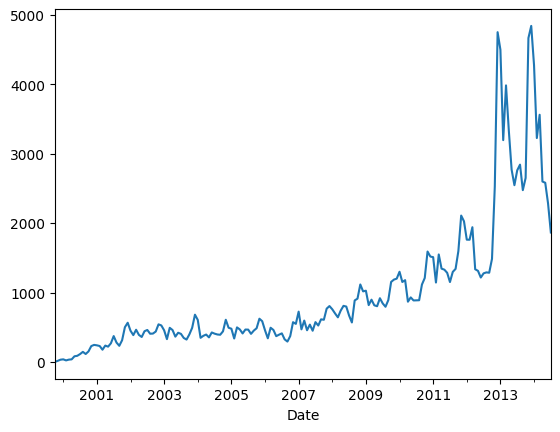

In [20]:
posi.plot()
plt.show()

## Check Stationarity of data 

In [22]:
# checking data stationary 
def check_data(data):
    pvalue = adfuller(data)[1]
    print("pvalue",pvalue)
    if pvalue < 0.05:
        msg = "Data is stationary"
    else:
        msg = "Data is not stationary"
    return msg

In [23]:
check_data(posi)

pvalue 0.9283384999656782


'Data is not stationary'

Converting the data to stationary by using shift 

In [24]:
for i in range(1,5):
    x =posi-posi.shift(i)
    x.dropna(inplace=True)
    msg = check_data(x)
    if msg == "Data is stationary":
        print("Shift value",i,msg)
        break

pvalue 0.007294135214202002
Shift value 1 Data is stationary


## Seasonal component visualization

In [26]:
# Decompose
def tsa_comp(df):
    decomp = seasonal_decompose(df, period=12, model='additive')

    d_trend = decomp.trend
    d_seasonal = decomp.seasonal
    d_resid = decomp.resid
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,8), facecolor='linen')
    plt.suptitle('TIME SERIES COMPONENT ANALYSIS', fontweight='bold', size=20)
    ax1.plot(df, label='Actual Sales')
    ax2.plot(d_trend, label='Trend', c='green')
    ax3.plot(d_seasonal, label='Seasonal', c='pink')
    ax4.plot(d_resid, label='resid', c='orange')
    fig.legend();

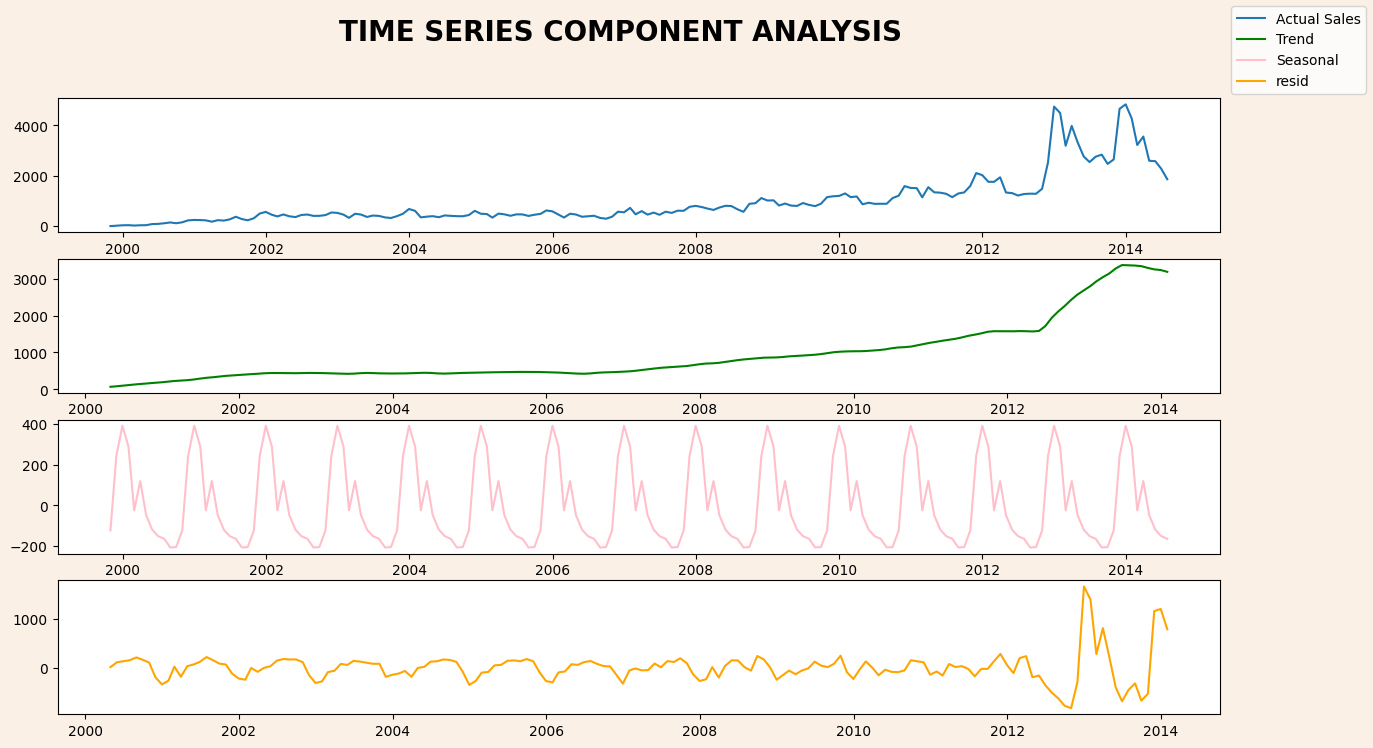

In [27]:
tsa_comp(posi)

## Finding P and Q using correlogram 

In [29]:
def p_and_q(d):
  fig,ax=plt.subplots(2,1,figsize=(6,7))
  plot_acf(d,lags=20,ax=ax[0])
  plot_pacf(d,lags=20,ax=ax[1]);


c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


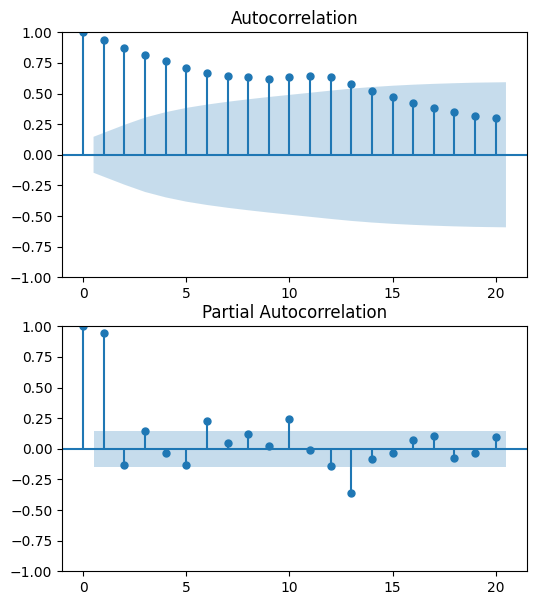

In [30]:
p_and_q(posi)

In [31]:
# Spliting data into train test 
samp = int(0.7*len(posi))

train  =posi.iloc[:samp]
test   = posi.iloc[samp:]

print(len(train))
print(len(test))

124
54


## AUTO-ARIMA 

In [32]:
# Using auto arima for for best p and q 
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=14, max_q=4,
                      m=30,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=1467.502, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=1475.620, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=1475.295, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=1474.603, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=1475.101, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=1465.698, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=1467.430, Time=0.61 sec
 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=1473.277, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=1474.415, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=1467.194, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=1467.403, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=1470.659, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[30] intercept   : AIC=1475.624, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[30]

## Model bulding

In [33]:
pos_mod = sm.tsa.statespace.SARIMAX(train,order=(1,1,3),seasonal_order=(1,1,3,30)).fit()
pp_model = pos_mod.fittedvalues
print(pos_mod.summary())

c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                       Sub-category   No. Observations:                  124
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 30)   Log Likelihood                -562.268
Date:                            Mon, 02 Oct 2023   AIC                           1142.537
Time:                                    10:06:29   BIC                           1165.330
Sample:                                10-31-1999   HQIC                          1151.740
                                     - 01-31-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5745      0.349     -1.645      0.100      -1.259       0.110
ma.L1          0.3178      0.321   

In [34]:
# checking model is good or not 
pvalue = sm.stats.acorr_ljungbox(pos_mod.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(pvalue)
if pvalue < 0.05:
    print('model is not  good')
else:
    print("model is good")

[0.99738453]
model is good


In [35]:
# Predicting on train data 
mypred= pos_mod.predict(0,len(train)-1)

In [80]:

print("mse :",mean_squared_error(train,mypred))
print("rmse :",mean_squared_error(train,mypred, squared = False))

mse : 7918.957087041895
rmse : 88.98852222080045


In [36]:
df_sarima_res_pos = pd.DataFrame({"Predictions":mypred})
df_sarima_res_pos["Actual"] = train
df_sarima_res_pos["err"] = df_sarima_res_pos["Actual"]-df_sarima_res_pos["Predictions"]

df_sarima_res_pos

,Predictions,Actual,err
Date,,,
1999-10-31,0.000000,1,1.000000
1999-11-30,0.997759,16,15.002241
1999-12-31,15.933852,33,17.066148
2000-01-31,32.935714,38,5.064286
2000-02-29,37.920225,23,-14.920225
...,...,...,...
2009-09-30,813.989553,891,77.010447
2009-10-31,906.305134,1152,245.694866
2009-11-30,1162.813275,1186,23.186725


## Forecasting 

In [39]:
forcast_1 = sm.tsa.statespace.SARIMAX(posi,order=(1,1,3),seasonal_order=(1,1,3,30)).fit()
forcast_mod = forcast_1.fittedvalues


c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [41]:
forcast_posi = forcast_1.forecast(60)

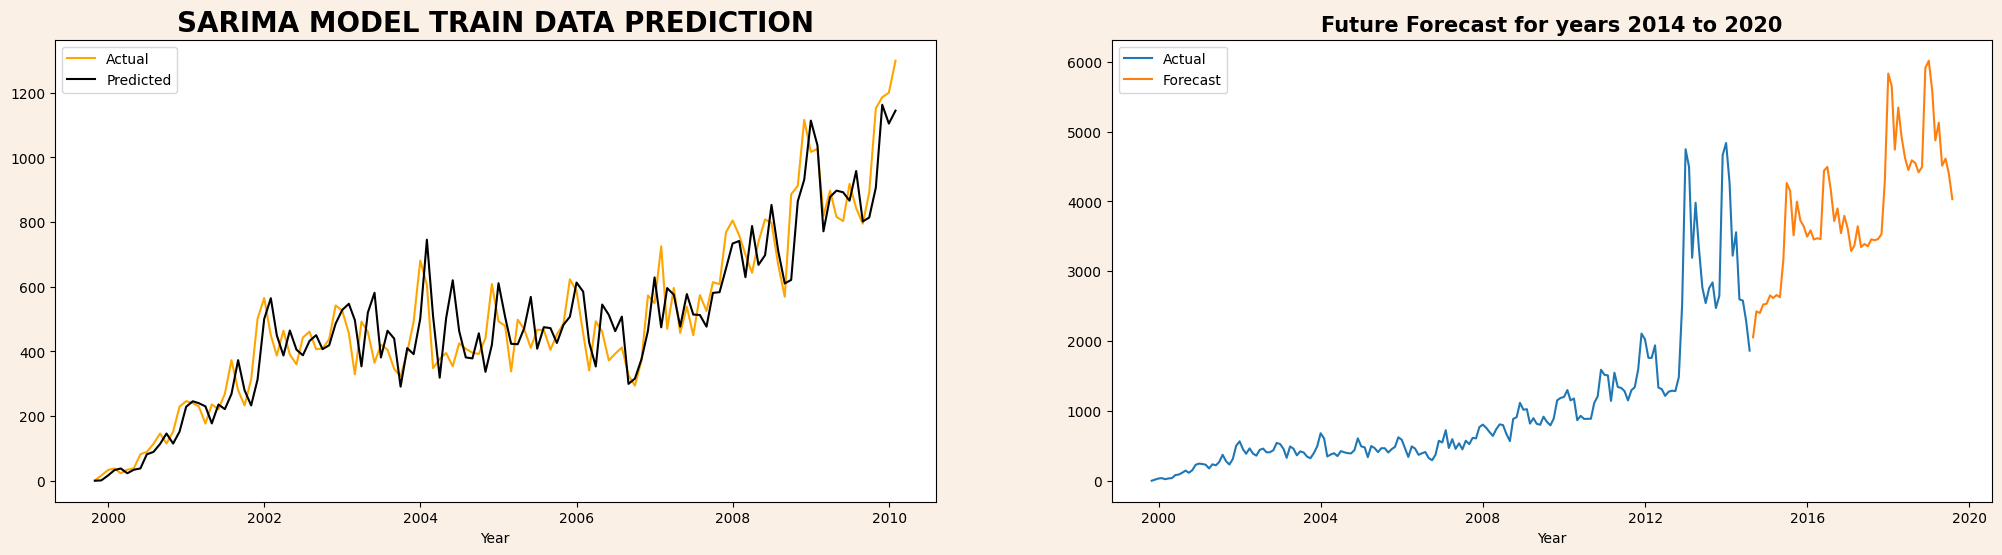

In [46]:
plt.subplots(figsize=(25,6), facecolor='linen')
plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.title(f'SARIMA MODEL TRAIN DATA PREDICTION', fontweight='bold', size=20)
plt.plot(train, c='orange',label="Actual")
plt.xlabel('Year')
plt.plot(mypred, c='black',label="Predicted")
plt.legend()


plt.subplot(1, 2, 2)
plt.title('Future Forecast for years 2014 to 2020', fontweight='bold',size=15)
plt.plot(posi, label = 'Actual')
plt.plot(forcast_posi, label = 'Forecast')
plt.xlabel('Year')
plt.legend()
plt.show()

# <CENTER> Video game negative reviews

In [47]:
df_neg=df_vd[df_vd['sentiment']=='Negative']['Sub-category']
df_neg

Date
2012-07-09           PC
2014-06-28           PC
2013-05-11           PC
2012-11-24           PC
2012-11-14           PC
                ...    
2014-07-09     Xbox One
2014-06-15     Xbox One
2014-06-14     Xbox One
2014-06-13     Xbox One
2014-05-29        Wii U
Name: Sub-category, Length: 56355, dtype: object

In [48]:
# resample the data by month
neg=df_neg.resample('M').count()

In [49]:
# checking data stationary 
check_data(neg)

pvalue 0.9326409948291126


'Data is not stationary'

In [50]:
for i in range(1,5):
    x = neg-neg.shift(i)
    x.dropna(inplace=True)
    msg = check_data(x)
    if msg == "Data is stationary":
        print("Shift value",i,msg)
        break

pvalue 0.0046744988889775435
Shift value 1 Data is stationary


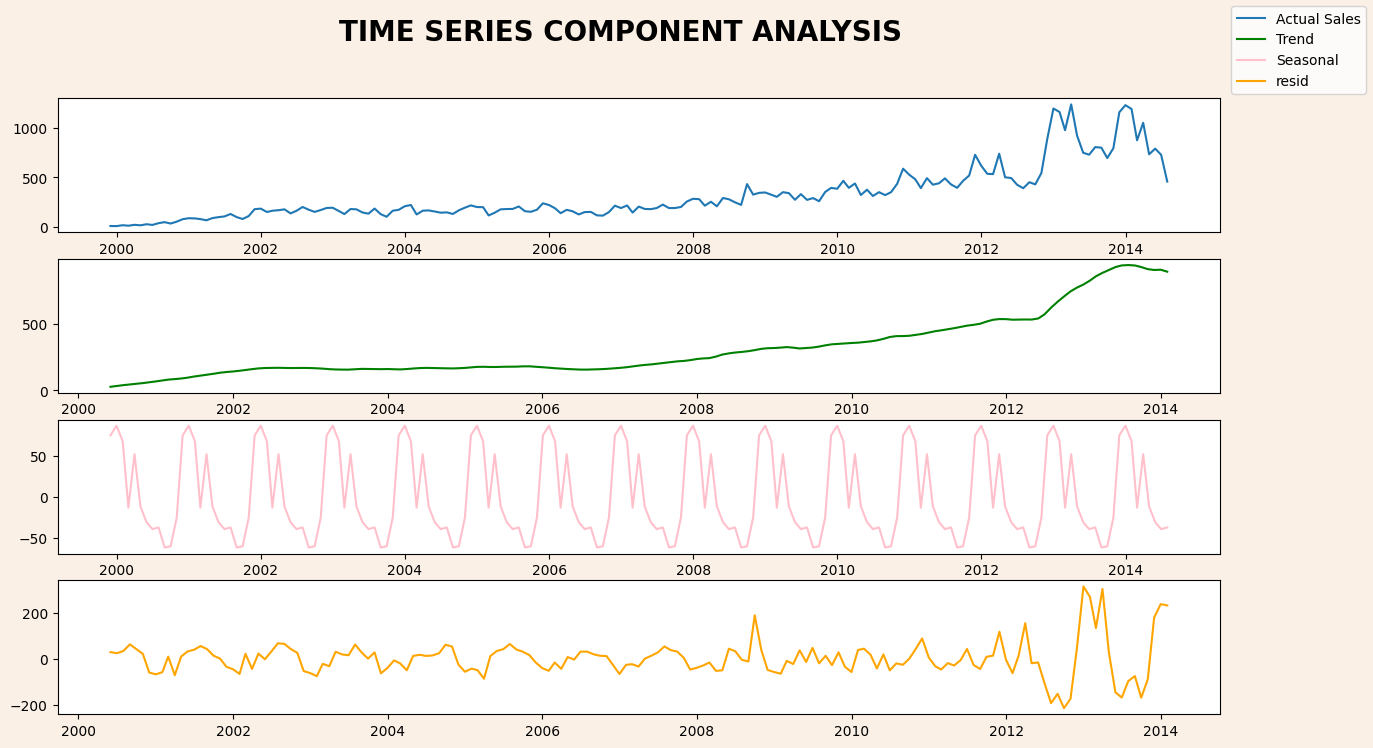

In [51]:
# Decompose
tsa_comp(neg)

c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


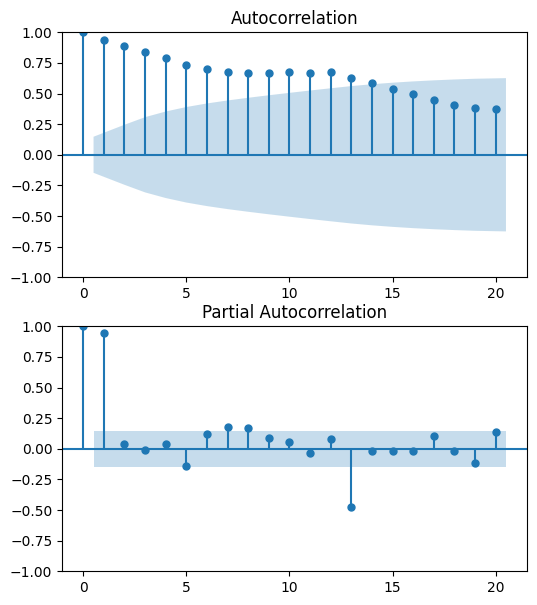

In [52]:
p_and_q(neg)

In [53]:
# Spliting data into train test 
samp = int(0.7*len(neg))

neg_train  =posi.iloc[:samp]
neg_test   = posi.iloc[samp:]

print(len(neg_train))
print(len(neg_test))

123
55


In [54]:
# Using auto arima for for best p and q 
model = auto_arima(neg_train, start_p=1, start_q=1,
                      test='adf',
                      max_p=14, max_q=4,
                      m=30,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=1453.923, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=1463.798, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=1463.664, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=1462.811, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=1463.072, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=1451.977, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=1453.902, Time=0.55 sec
 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=1461.331, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=1462.583, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=1453.092, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=1453.505, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=1456.876, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[30] intercept   : AIC=1463.752, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[30]

## Model bulding

In [55]:
neg_mod = sm.tsa.statespace.SARIMAX(neg_train,order=(1,1,3),seasonal_order=(1,1,3,30)).fit()
neg_model = neg_mod.fittedvalues
print(neg_mod.summary())

c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                       Sub-category   No. Observations:                  123
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 30)   Log Likelihood                -555.021
Date:                            Mon, 02 Oct 2023   AIC                           1128.043
Time:                                    10:22:04   BIC                           1150.739
Sample:                                10-31-1999   HQIC                          1137.203
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5559      0.307     -1.808      0.071      -1.158       0.047
ma.L1          0.2825      0.276   

In [56]:
# checking model is good or not 
pvalue = sm.stats.acorr_ljungbox(neg_mod.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(pvalue)
if pvalue < 0.05:
    print('model is not  good')
else:
    print("model is good")

[0.99415928]
model is good


In [57]:
# Predicting on train data 
neg_pred= neg_mod.predict(0,len(neg_train)-1)

In [58]:
print("mse :",mean_squared_error(neg_train,neg_pred))
print("rmse :",mean_squared_error(neg_train,neg_pred, squared = False))

mse : 8430.668963396103
rmse : 91.81867437180796


### Forcasting

In [63]:
forcast_neg_mod = sm.tsa.statespace.SARIMAX(neg,order=(1,1,3),seasonal_order=(1,1,3,30)).fit()
forcast_neg_model = forcast_neg_mod.fittedvalues
print(forcast_neg_mod.summary())

c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                                     SARIMAX Results                                      
Dep. Variable:                       Sub-category   No. Observations:                  177
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 30)   Log Likelihood                -877.471
Date:                            Mon, 02 Oct 2023   AIC                           1772.943
Time:                                    10:26:03   BIC                           1799.795
Sample:                                11-30-1999   HQIC                          1783.854
                                     - 07-31-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6882      0.114      6.027      0.000       0.464       0.912
ma.L1         -0.8197      0.113   

In [64]:

neg_forecast = forcast_neg_mod.forecast(60)

In [65]:
sarima_neg = pd.DataFrame({"Predictions":neg_pred})
sarima_neg["Actual"] = neg_train
sarima_neg["err"] = sarima_neg["Actual"]-sarima_neg["Predictions"]

sarima_neg

,Predictions,Actual,err
Date,,,
1999-10-31,0.000000,1,1.000000
1999-11-30,0.997494,16,15.002506
1999-12-31,15.926141,33,17.073859
2000-01-31,32.929406,38,5.070594
2000-02-29,37.905613,23,-14.905613
...,...,...,...
2009-08-31,815.658472,795,-20.658472
2009-09-30,815.801097,891,75.198903
2009-10-31,908.004396,1152,243.995604


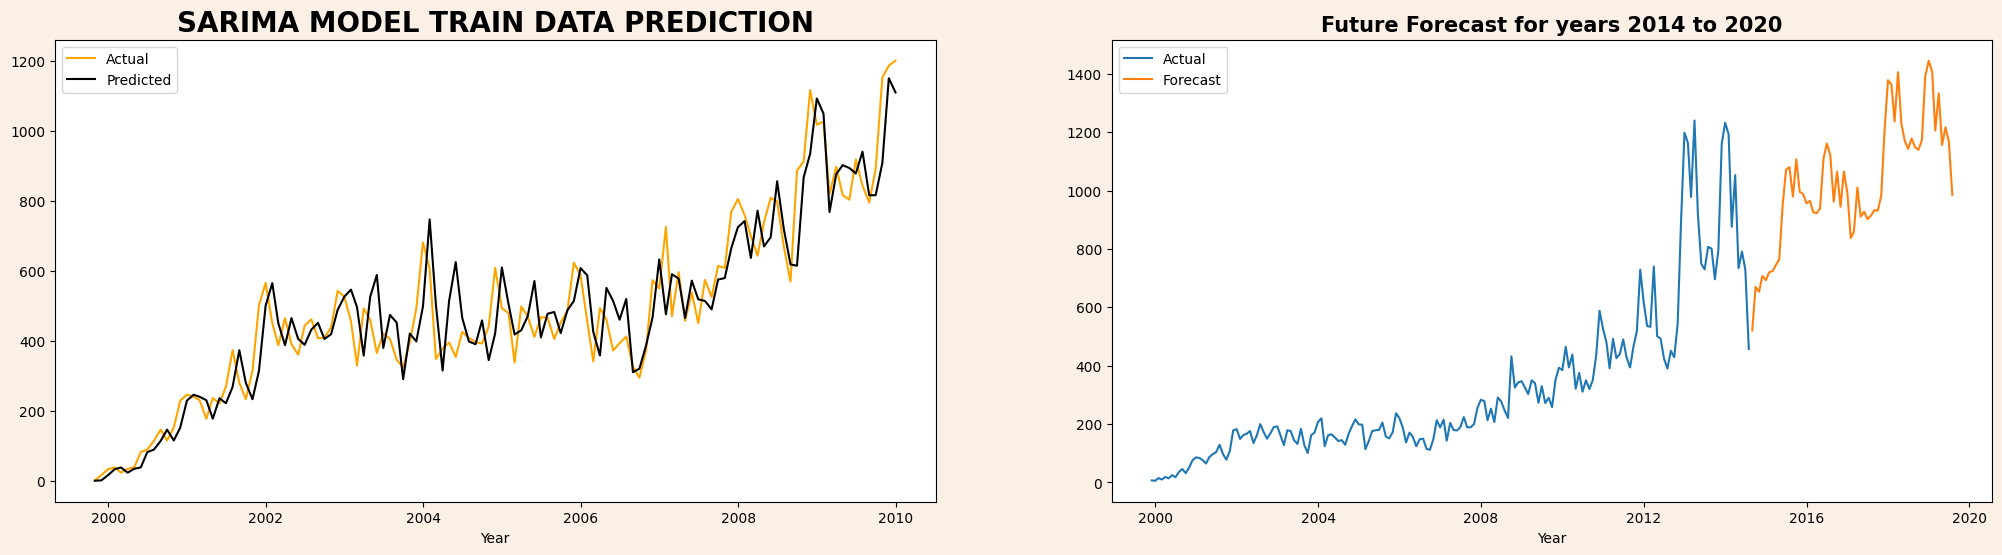

In [67]:

plt.subplots(figsize=(25,6), facecolor='linen')
plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.title(f'SARIMA MODEL TRAIN DATA PREDICTION', fontweight='bold', size=20)
plt.plot(neg_train, c='orange',label="Actual")
plt.xlabel('Year')
plt.plot(neg_pred, c='black',label="Predicted")
plt.legend()


plt.subplot(1, 2, 2)
plt.title('Future Forecast for years 2014 to 2020', fontweight='bold',size=15)
plt.plot(neg, label = 'Actual')
plt.plot(neg_forecast, label = 'Forecast')
plt.xlabel('Year')
plt.legend()
plt.show()
     

# <CENTER> TOYS and GAMES


In [68]:
# Load the data 
df_TG=pd.read_csv(r"C:\Users\vasan_z56icq7\Downloads\T&G_Data.csv")
df_TG.head()

,reviewerID,ProductID,reviewerName,overall,Date,text,senti_score,sentiment,title,price,Category,Sub-category,also_buy
0,A1VXOAVRGKGEAK,0439893577,Angie,5.0,2014-01-29,like item pricing granddaughter wanted mark wa...,0.000000,Neutral,Little Red Tool Box: Magnetic Tabletop Learnin...,16.19,Toys & Games,Dress Up & Pretend Play,1
1,A8R62G708TSCM,0439893577,Candace,4.0,2014-03-28,love magnet easel great moving different area ...,0.375000,Positive,Little Red Tool Box: Magnetic Tabletop Learnin...,16.19,Toys & Games,Dress Up & Pretend Play,1
2,A21KH420DK0ICA,0439893577,capemaychristy,5.0,2013-01-28,side magnetic real plus entertaining one child...,0.241071,Positive,Little Red Tool Box: Magnetic Tabletop Learnin...,16.19,Toys & Games,Dress Up & Pretend Play,1
3,AR29QK6HPFYZ4,0439893577,dcrm,5.0,2014-02-08,bought one year ago daughter love still using ...,0.566667,Positive,Little Red Tool Box: Magnetic Tabletop Learnin...,16.19,Toys & Games,Dress Up & Pretend Play,1
4,ACCH8EOML6FN5,0439893577,DoyZ,4.0,2014-05-05,stainless steel refrigerator therefore much sp...,0.500000,Positive,Little Red Tool Box: Magnetic Tabletop Learnin...,16.19,Toys & Games,Dress Up & Pretend Play,1


In [69]:
# checking null values
df_TG.isnull().sum()

reviewerID       0
ProductID        0
reviewerName    12
overall          0
Date             0
text             0
senti_score      0
sentiment        0
title            0
price            0
Category         0
Sub-category     0
also_buy         0
dtype: int64

In [70]:
# Droping null values 
df_TG.dropna(inplace=True)

In [71]:
#checking the number of records and features in TOYs and GAMES dataset
df_TG.shape

(167585, 13)

In [72]:
df_TG.sort_values(by=["Date"],inplace=True)

In [73]:
# converting date to date and time
df_TG["Date"] = pd.to_datetime(df_TG["Date"])

In [74]:
df_TG=df_TG.set_index('Date')
df_TG.head(2)

,reviewerID,ProductID,reviewerName,overall,text,senti_score,sentiment,title,price,Category,Sub-category,also_buy
Date,,,,,,,,,,,,
2000-07-28,A2B8GXSCB1R05T,B00004SDAP,Zack Davisson,5.0,one favorite game young one tricky game much f...,0.129444,Positive,Mille Bornes Collectors Edition,2.73,Toys & Games,Games,1
2000-08-15,A32JIQG3B1XX5I,B00000IW2S,Rebecca Martin,2.0,bought son knowing playskool pretty good brand...,0.167045,Positive,Playskool Busy Basics Form Fitter (Colors May ...,9.71,Toys & Games,Learning & Education,1


# <CENTER> Toys and games Positive data 

In [76]:
tg_posi=df_TG[df_TG['sentiment']=='Positive']['Sub-category']
tg_posi

Date
2000-07-28                    Games
2000-08-15     Learning & Education
2000-08-31                    Games
2000-09-04     Learning & Education
2000-09-04      Baby & Toddler Toys
                      ...          
2014-07-23      Dolls & Accessories
2014-07-23            Building Toys
2014-07-23            Building Toys
2014-07-23      Dolls & Accessories
2014-07-23                  Hobbies
Name: Sub-category, Length: 154811, dtype: object

In [77]:
# resample the data by month
tg_posi=tg_posi.resample('M').count()

<AxesSubplot:xlabel='Date'>

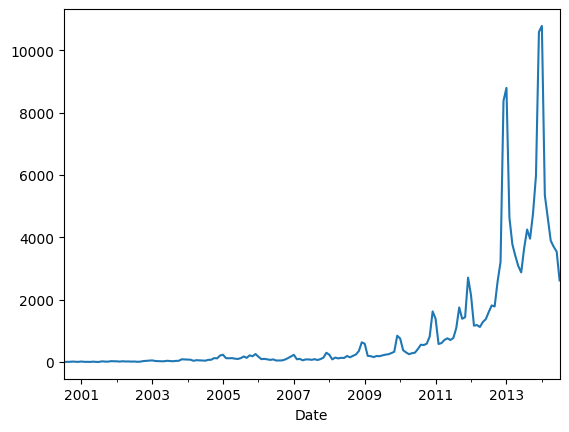

In [78]:
tg_posi.plot()

In [79]:
# checking data stationary 
for i in range(1,10):
    x = tg_posi-tg_posi.shift(i)
    x.dropna(inplace=True)
    msg = check_data(x)
    if msg == "Data is stationary":
        print("Shift value",i,msg)
        break

pvalue 0.13922621660001655
pvalue 0.25723048966342327
pvalue 0.47142527988739413
pvalue 0.4034266741743492
pvalue 0.19663411889433513
pvalue 0.2975932962798635
pvalue 0.5464086864763611
pvalue 0.006359886923687551
Shift value 8 Data is stationary


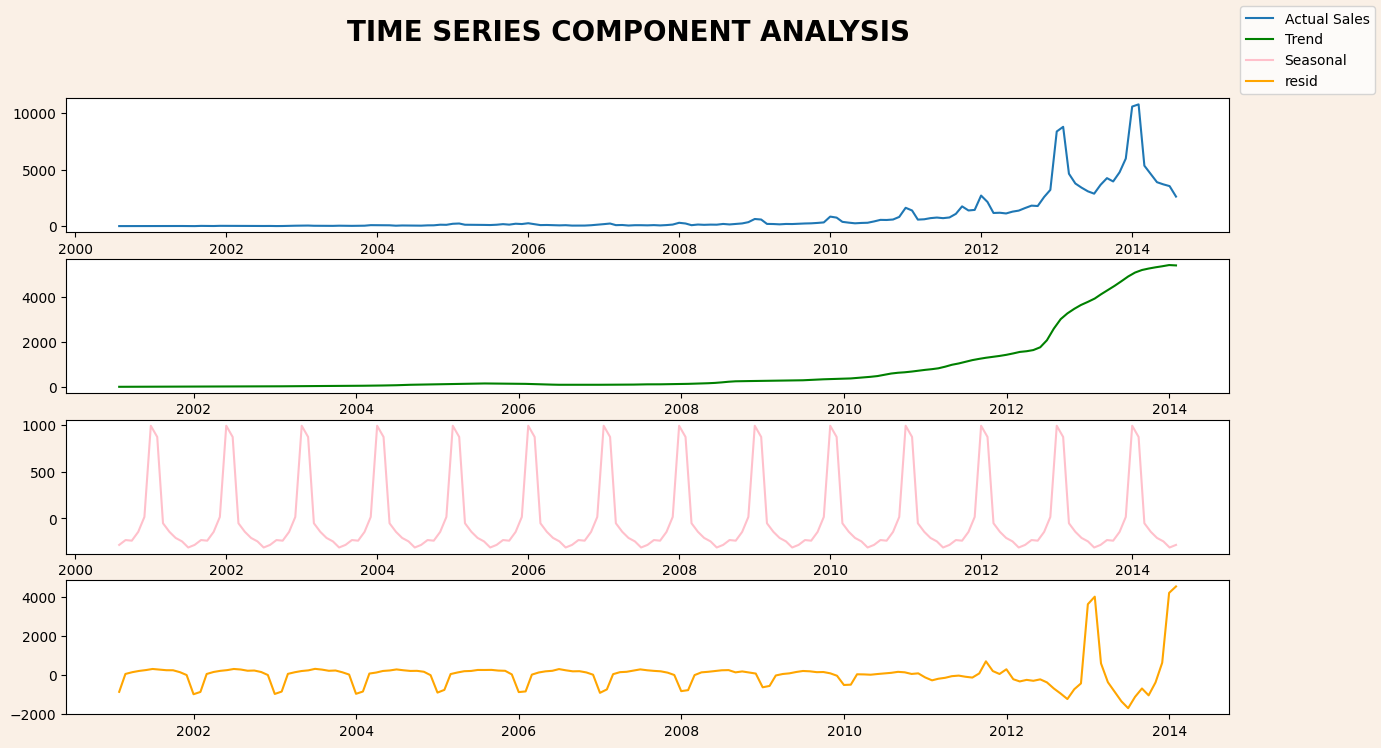

In [80]:
# Decompose
tsa_comp(tg_posi)

In [142]:
def p_and_q(d):
  fig,ax=plt.subplots(2,1,figsize=(6,7))
  plot_acf(d,lags=20,ax=ax[0])
  plot_pacf(d,lags=20,ax=ax[1]);

c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


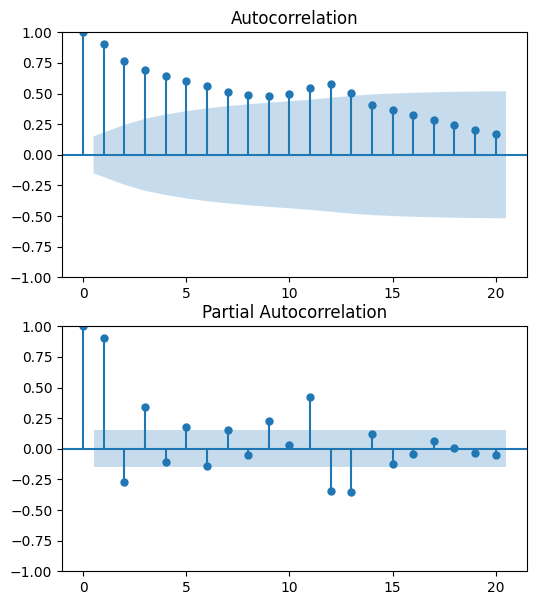

In [81]:
p_and_q(tg_posi)

In [82]:
# Spliting data into train test 
samp = int(0.7*len(tg_posi))

tg_posi_train  =tg_posi.iloc[:samp]
tg_posi_test = tg_posi.iloc[samp:]

print(len(tg_posi_train))
print(len(tg_posi_test))

118
51


In [83]:
# Using auto arima for for best p and q 
model = auto_arima(tg_posi, start_p=1, start_q=1,
                      test='adf',
                      max_p=13, max_q=5,
                      m=30,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=2691.206, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=2727.853, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=2725.812, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=2712.908, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=2725.919, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=2689.505, Time=0.11 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=2691.091, Time=0.44 sec
 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=2692.648, Time=1.03 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=2711.012, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=2724.261, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=2687.779, Time=0.13 sec
 ARIMA(2,1,1)(1,0,0)[30] intercept   : AIC=2689.197, Time=0.98 sec
 ARIMA(2,1,1)(0,0,1)[30] intercept   : AIC=2689.360, Time=0.87 sec
 ARIMA(2,1,1)(1,0,1)[30] intercept   : AIC=2690.731, Time=1.19 sec
 ARIMA(2,1,0)(0,0,0

### Model bulding

In [84]:
tg_posi_mod = sm.tsa.statespace.SARIMAX(tg_posi_train,order=(1,1,2),seasonal_order=(1,1,2,30)).fit()
tg_posi_model = tg_posi_mod.fittedvalues
print(tg_posi_mod.summary())

c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                                     SARIMAX Results                                      
Dep. Variable:                       Sub-category   No. Observations:                  118
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 30)   Log Likelihood                -516.770
Date:                            Mon, 02 Oct 2023   AIC                           1047.540
Time:                                    10:29:02   BIC                           1064.801
Sample:                                07-31-2000   HQIC                          1054.491
                                     - 04-30-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4607      0.212      2.174      0.030       0.045       0.876
ma.L1         -0.5791      0.243   

In [85]:
# checking model is good or not 
pvalue = sm.stats.acorr_ljungbox(tg_posi_mod.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(pvalue)
if pvalue < 0.05:
    print('model is not  good')
else:
    print("model is good")

[0.91514301]
model is good


In [86]:
# Predicting on train data 
tg_posi_pred= tg_posi_mod.predict(0,len(tg_posi_train)-1)

In [87]:
print("mse :",mean_squared_error(tg_posi_train,tg_posi_pred))
print("rmse :",mean_squared_error(tg_posi_train,tg_posi_pred, squared = False))

mse : 5496.92349472263
rmse : 74.14124017524006


## Forecasting

In [89]:
for_tg_posi_mod = sm.tsa.statespace.SARIMAX(tg_posi,order=(1,1,2),seasonal_order=(1,1,2,30)).fit()
for_tg_posi_model = for_tg_posi_mod.fittedvalues
print(for_tg_posi_mod.summary())

c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                                     SARIMAX Results                                      
Dep. Variable:                       Sub-category   No. Observations:                  169
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 30)   Log Likelihood               -1109.015
Date:                            Mon, 02 Oct 2023   AIC                           2232.029
Time:                                    10:31:44   BIC                           2252.520
Sample:                                07-31-2000   HQIC                          2240.356
                                     - 07-31-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3570      0.166      2.156      0.031       0.032       0.682
ma.L1         -0.0137      0.140   

In [90]:
tg_posi_forecast = for_tg_posi_mod.forecast(60)

In [91]:
sarima_tg_posi = pd.DataFrame({"Predictions":tg_posi_pred})
sarima_tg_posi["Actual"] = tg_posi_train
sarima_tg_posi["err"] = sarima_tg_posi["Actual"]-sarima_tg_posi["Predictions"]

sarima_tg_posi

,Predictions,Actual,err
Date,,,
2000-07-31,0.000000,1,1.000000
2000-08-31,1.000064,2,0.999936
2000-09-30,1.998403,3,1.001597
2000-10-31,2.995905,11,8.004095
2000-11-30,10.995592,7,-3.995592
...,...,...,...
2009-12-31,355.745772,842,486.254228
2010-01-31,765.834501,751,-14.834501
2010-02-28,502.451553,377,-125.451553


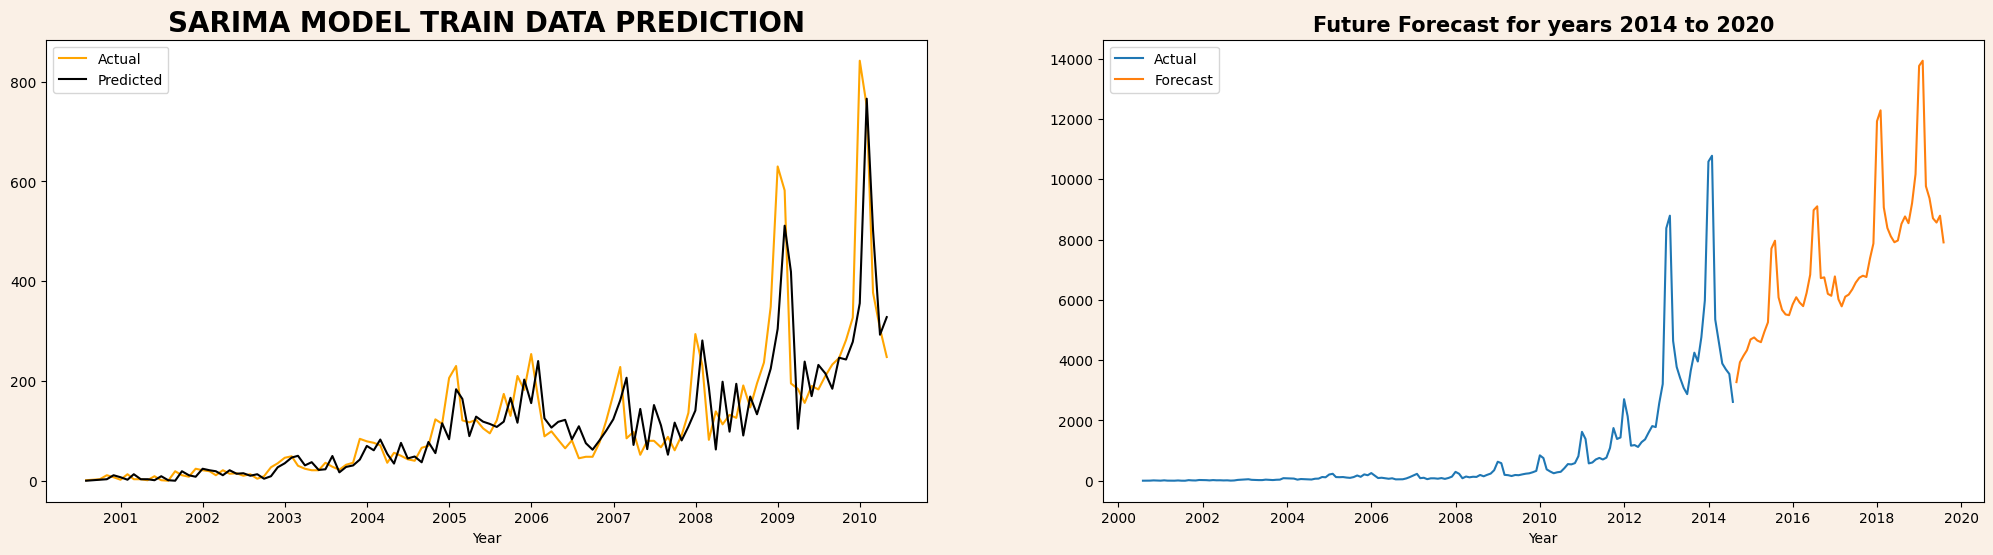

In [93]:

plt.subplots(figsize=(25,6), facecolor='linen')
plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.title(f'SARIMA MODEL TRAIN DATA PREDICTION', fontweight='bold', size=20)
plt.plot(tg_posi_train, c='orange',label="Actual")
plt.plot(tg_posi_pred, c='black',label="Predicted")
plt.xlabel('Year')
plt.legend()


plt.subplot(1, 2, 2)
plt.title('Future Forecast for years 2014 to 2020', fontweight='bold',size=15)
plt.plot(tg_posi, label = 'Actual')
plt.plot(tg_posi_forecast, label = 'Forecast')
plt.xlabel('Year')
plt.legend()
plt.show()

# <CENTER> Toys and games negative review 


In [112]:
tg_neg=df_TG[df_TG['sentiment']=='Negative']['Sub-category']
tg_neg

Date
2000-10-10                                  Games
2000-12-02                                  Games
2001-01-15                                  Games
2001-01-15                                  Games
2001-01-17     Toy Remote Control & Play Vehicles
                             ...                 
2014-07-21                                  Games
2014-07-21                                  Games
2014-07-21                    Dolls & Accessories
2014-07-22                                  Games
2014-07-22                                  Games
Name: Sub-category, Length: 11687, dtype: object

In [113]:
# resample the data by month
tg_neg=tg_neg.resample('M').count()

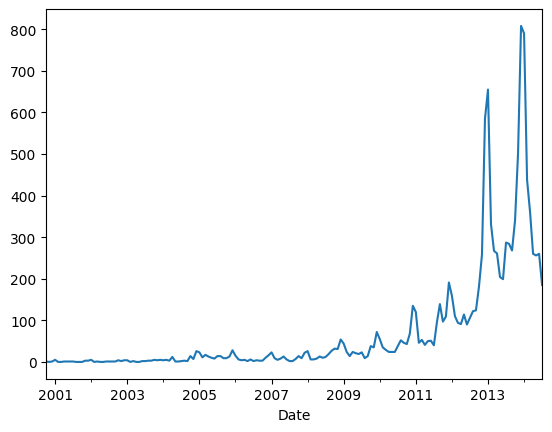

In [114]:
tg_neg.plot()
plt.show()

In [97]:
# checking data stationary 
check_data(tg_neg)

pvalue 0.9975613312293878


'Data is not stationary'

In [115]:
for i in range(1,10):
    x = tg_neg-tg_neg.shift(i)
    x.dropna(inplace=True)
    msg = check_data(x)
    if msg == "Data is stationary":
        print("Shift value",i,msg)
        break

pvalue 0.009806578380345843
Shift value 1 Data is stationary


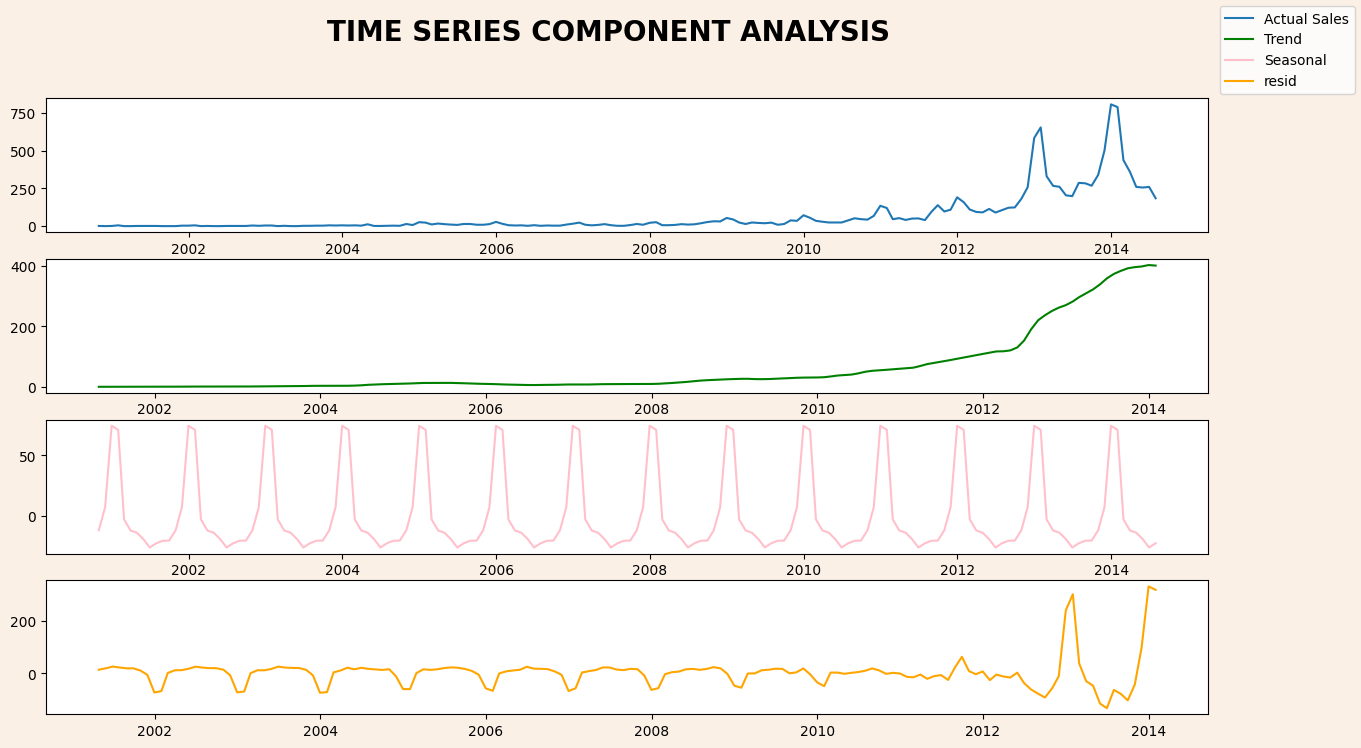

In [116]:
# Decompose
tsa_comp(tg_neg)

c:\Users\vasan_z56icq7\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


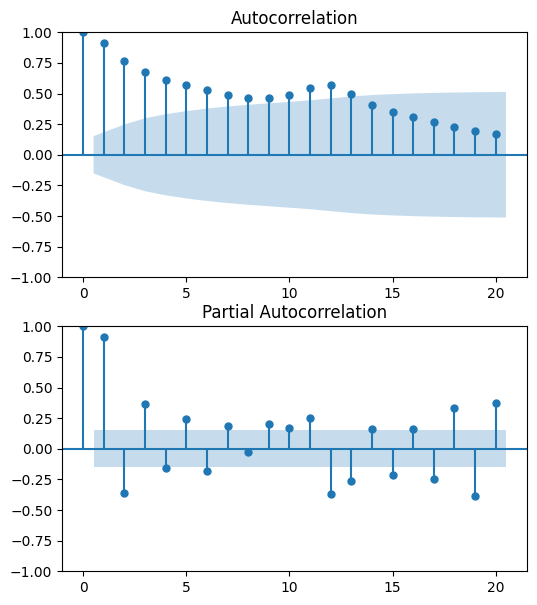

In [100]:
p_and_q(tg_neg)

In [101]:
# Spliting data into train test 
samp = int(0.7*len(tg_neg))

tg_neg_train  =tg_neg.iloc[:samp]
tg_neg_test = tg_neg.iloc[samp:]

print(len(tg_neg_train))
print(len(tg_neg_test))

116
50


In [102]:
# Using auto arima for for best p and q 
model = auto_arima(tg_neg_train, start_p=1, start_q=1,
                      test='adf',
                      max_p=14, max_q=14,
                      m=1,             
                      d=1,          
                      seasonal=30,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=806.298, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=806.737, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=806.118, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=804.371, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.259 seconds


## Model bulding 

In [103]:
tg_neg_mod = sm.tsa.statespace.SARIMAX(tg_neg_train,order=(0,1,0),seasonal_order=(0,1,0,30)).fit()
tg_neg_model = tg_neg_mod.fittedvalues
print(tg_neg_mod.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Sub-category   No. Observations:                  116
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 30)   Log Likelihood                -322.603
Date:                            Mon, 02 Oct 2023   AIC                            647.206
Time:                                    10:33:41   BIC                            649.648
Sample:                                10-31-2000   HQIC                           648.188
                                     - 05-31-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       115.9057     12.213      9.490      0.000      91.969     139.843
Ljung-Box (L1) (Q):                

In [104]:
# checking model is good or not 
pvalue = sm.stats.acorr_ljungbox(tg_neg_mod.resid,lags=[1],return_df=True)['lb_pvalue'].values
print(pvalue)
if pvalue < 0.05:
    print('model is not  good')
else:
    print("model is good")

[0.16711956]
model is good


In [105]:

# Predicting on train data tg_neg_pred= tg_neg_mod.predict(0,len(tg_neg_train)-1)

In [106]:
print("mse :",mean_squared_error(tg_neg_train,tg_neg_pred))
print("rmse :",mean_squared_error(tg_neg_train,tg_neg_pred, squared = False))

mse : 86.0538805592414
rmse : 9.276523085684712


### Forecasting


In [120]:
for_tg_neg_mod = sm.tsa.statespace.SARIMAX(tg_neg,order=(0,1,0),seasonal_order=(0,1,0,30)).fit()
for_tg_neg_model = for_tg_neg_mod.fittedvalues
print(for_tg_neg_mod.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Sub-category   No. Observations:                  166
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 30)   Log Likelihood                -762.301
Date:                            Mon, 02 Oct 2023   AIC                           1526.601
Time:                                    10:38:43   BIC                           1529.506
Sample:                                10-31-2000   HQIC                          1527.782
                                     - 07-31-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4699.1952    181.914     25.832      0.000    4342.650    5055.740
Ljung-Box (L1) (Q):                

In [122]:
tg_neg_forecast = for_tg_neg_mod.forecast(60)

In [123]:
sarima_tg_neg = pd.DataFrame({"Predictions":tg_neg_pred})
sarima_tg_neg["Actual"] = tg_neg_train
sarima_tg_neg["err"] = sarima_tg_neg["Actual"]-sarima_tg_neg["Predictions"]

sarima_tg_neg

,Predictions,Actual,err
Date,,,
2000-10-31,0.0,1,1.0
2000-11-30,1.0,0,-1.0
2000-12-31,0.0,1,1.0
2001-01-31,1.0,5,4.0
2001-02-28,5.0,0,-5.0
...,...,...,...
2010-01-31,68.0,55,-13.0
2010-02-28,55.0,35,-20.0
2010-03-31,40.0,29,-11.0


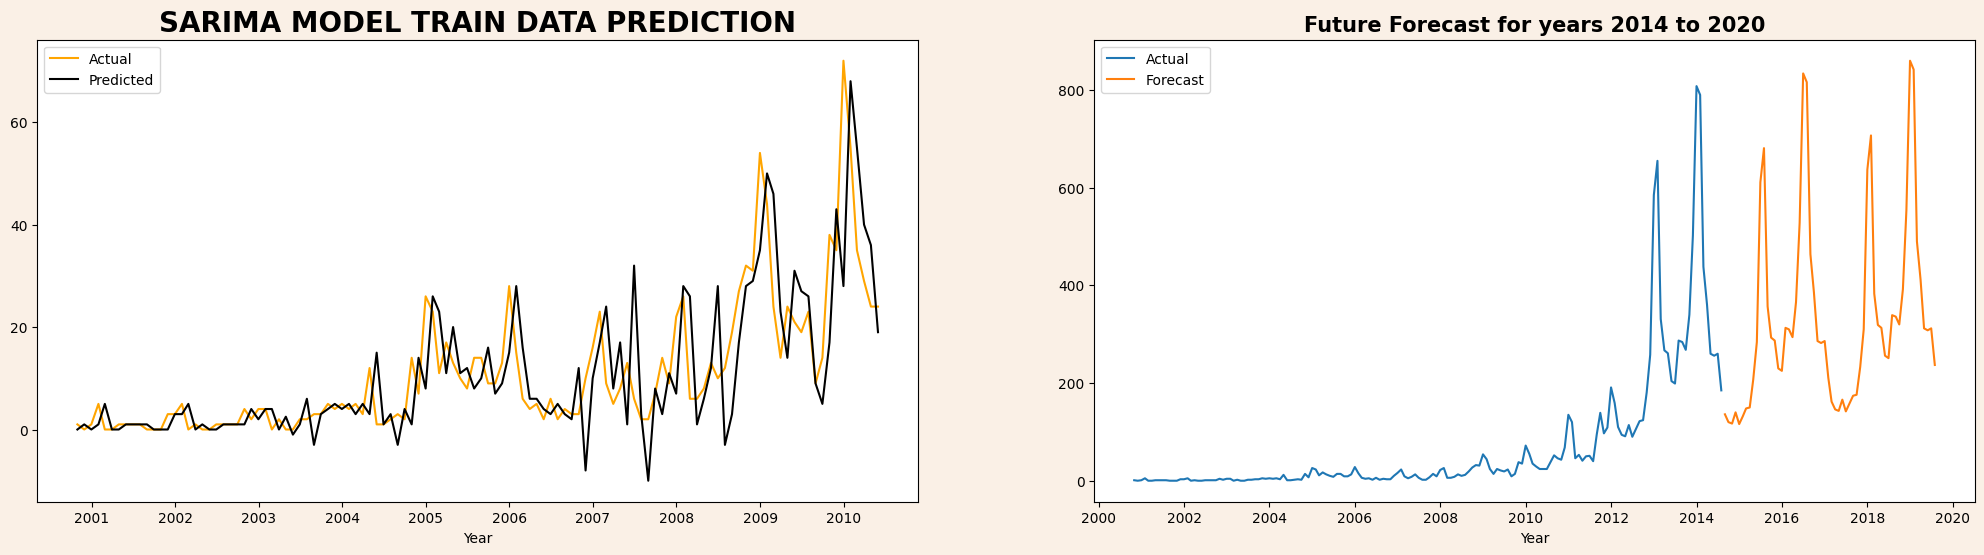

In [125]:
plt.subplots(figsize=(25,6), facecolor='linen')
plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.title(f'SARIMA MODEL TRAIN DATA PREDICTION', fontweight='bold', size=20)
plt.plot(tg_neg_train, c='orange',label="Actual")
plt.plot(tg_neg_pred, c='black',label="Predicted")
plt.xlabel('Year')
plt.legend()


plt.subplot(1, 2, 2)
plt.title('Future Forecast for years 2014 to 2020', fontweight='bold',size=15)
plt.plot(tg_neg, label = 'Actual')
plt.plot(tg_neg_forecast, label = 'Forecast')
plt.xlabel('Year')
plt.legend()
plt.show()

## Conclusion 

## *For Video games dataset both graphs for positive and negative reviews exhibit an upward trend, indicating a potential increase in the future. 

## *Positive reviews of the product show two significant peaks in 2018 and 2020, while negative reviews also shows peaks with sharp decline this suggests there is no significant change over time for Toys & Games dataset.

# ------------------------------------------------